In [2]:
daimport os
import pickle

import pandas as pd
import numpy as np

from pathlib import Path

import chart_studio.plotly as py
import plotly.graph_objects as go
import plotly.express as px

from datetime import datetime

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import plot_confusion_matrix
from sklearn.tree import export_graphviz
from sklearn.inspection import permutation_importance

import matplotlib.pyplot as plt

In [95]:
pd.options.display.max_rows = 999

In [3]:
model_base_path = "../../data/models/precipitation"
OK = 1
ERROR = 0

In [4]:
# ! pip install chart-studio plotly plotly-geo
# ! pip install plotly
# ! pip uninstall -y chart-studio plotly
# !pip install plotly==3.10.0

In [5]:
!ls ../../data/stations

benque_prec.csv                 hawkesworth_bridge_wtlv_min.csv
central_farm_prec.csv           santa_elena_prec.csv
chaa_creek_prec.csv             santa_elena_wtlv1.csv
hawkesworth_bridge_prec.csv     santa_elena_wtlv_max.csv
hawkesworth_bridge_wtlv1.csv    santa_elena_wtlv_min.csv
hawkesworth_bridge_wtlv_max.csv


In [6]:
df_all = None
for f in Path('../../data/stations').rglob('*_prec*.csv'):
    
    if "benque" in str(f) or "santa" in str(f):
        continue
    
    station = os.path.basename(f).split('_prec')[0]
    print(station)
    _df = pd.read_csv(f, parse_dates=["datetime", "updated_at"])
    _df['station'] = station
    if df_all is None:
        df_all = _df
    else:
        df_all = pd.concat([df_all, _df], ignore_index=True)

central_farm
hawkesworth_bridge
chaa_creek


In [7]:
df_all.drop(columns=['updated_at', 'variable_id'], inplace=True)
df_all.head()

datetime  measured  station_id       station
0 2020-04-19 02:00:00+00:00       0.0         169  central_farm
1 2020-04-19 02:05:00+00:00       0.0         169  central_farm
2 2020-04-19 02:10:00+00:00       0.0         169  central_farm
3 2020-04-19 02:15:00+00:00       0.0         169  central_farm
4 2020-04-19 02:20:00+00:00       0.0         169  central_farm

In [8]:
df_day = df_all.groupby([pd.Grouper(key="datetime", freq="1h"), "station", "station_id"]).sum()
df_day.reset_index(inplace=True)
df_day.head()

datetime       station  station_id  measured
0 2020-04-19 00:00:00+00:00  central_farm         169       0.0
1 2020-04-19 01:00:00+00:00  central_farm         169       0.0
2 2020-04-19 02:00:00+00:00  central_farm         169       0.0
3 2020-04-19 03:00:00+00:00  central_farm         169       0.0
4 2020-04-19 04:00:00+00:00  central_farm         169       0.0

In [9]:
fig = px.bar(df_day, 
             x="datetime", 
             y='measured', 
             color='station',
             barmode='group',
             title='Time Series with Range Slider and Selectors')

fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1d", step="day", stepmode="backward"),
            dict(count=7, label="7d", step="day", stepmode="backward"),
            dict(count=10, label="10d", step="day", stepmode="backward"),
            dict(count=14, label="14d", step="day", stepmode="backward"),            
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=6, label="6m", step="month", stepmode="backward"),
            dict(count=1, label="YTD", step="year", stepmode="todate"),
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(step="all")
        ])
    )
)

In [10]:
df_day.groupby(['station']).agg({'datetime':[np.min, np.max]})

datetime                          
                                        amin                      amax
station                                                               
central_farm       2020-04-19 00:00:00+00:00 2020-11-30 11:00:00+00:00
chaa_creek         2020-05-04 06:00:00+00:00 2020-11-30 11:00:00+00:00
hawkesworth_bridge 2020-06-24 23:00:00+00:00 2020-11-30 11:00:00+00:00

In [11]:
data_all = df_day[['station', 'measured', 'datetime']].pivot(index='datetime', columns='station', values='measured')
data_all.sort_index(inplace=True)
data_all

station                    central_farm  chaa_creek  hawkesworth_bridge
datetime                                                               
2020-04-19 00:00:00+00:00           0.0         NaN                 NaN
2020-04-19 01:00:00+00:00           0.0         NaN                 NaN
2020-04-19 02:00:00+00:00           0.0         NaN                 NaN
2020-04-19 03:00:00+00:00           0.0         NaN                 NaN
2020-04-19 04:00:00+00:00           0.0         NaN                 NaN
...                                 ...         ...                 ...
2020-11-30 07:00:00+00:00           0.0         0.0                 0.0
2020-11-30 08:00:00+00:00           0.0         0.0                 0.0
2020-11-30 09:00:00+00:00           0.0         0.0                 0.0
2020-11-30 10:00:00+00:00           0.0         0.0                 0.0
2020-11-30 11:00:00+00:00           0.0         0.0                 0.0

[5412 rows x 3 columns]

In [12]:
# dropna 
print(f"data before dropna: shape={data_all.shape}")
data = data_all.dropna().copy()
print(f"data after  dropna: shape={data.shape}")

data.loc[:, 'label'] = OK

data.head()

data before dropna: shape=(5412, 3)
data after  dropna: shape=(3805, 3)


station                    central_farm  chaa_creek  hawkesworth_bridge  label
datetime                                                                      
2020-06-24 23:00:00+00:00           0.0         0.0                 0.0      1
2020-06-25 00:00:00+00:00           0.0         0.0                 0.0      1
2020-06-25 01:00:00+00:00           0.0         0.0                 0.0      1
2020-06-25 02:00:00+00:00           0.0         0.0                 0.0      1
2020-06-25 03:00:00+00:00           0.0         0.0                 0.0      1

In [13]:
fig = go.Figure(data=[
#     go.Bar(name='avg', x=data.index, y=data.avg),
#     go.Bar(name='santa_elena', x=data.index, y=data.santa_elena, text=data.label),
#     go.Bar(name='santa_elena', x=data.index, y=data.santa_elena),
    go.Bar(name='central_farm', x=data.index, y=data.central_farm),
    go.Bar(name='hawkesworth_bridge', x=data.index, y=data.hawkesworth_bridge),
    go.Bar(name='chaa_creek', x=data.index, y=data.chaa_creek)
])

# Change the bar mode
fig.update_layout(barmode='group')

fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1d", step="day", stepmode="backward"),
            dict(count=7, label="7d", step="day", stepmode="backward"),
            dict(count=10, label="10d", step="day", stepmode="backward"),
            dict(count=14, label="14d", step="day", stepmode="backward"),            
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=6, label="6m", step="month", stepmode="backward"),
            dict(count=1, label="YTD", step="year", stepmode="todate"),
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(step="all")
        ])
    )
)

fig.show()

In [14]:
def split_df(df, x_columns, y_column, day):
    
    df = df.reset_index()
    
    df_slice = df[df.datetime.dt.date < day] 
    X_train = df_slice[x_columns]
    y_train = df_slice[y_column]
    
    df_slice = df[df.datetime.dt.date >= day] 
    X_test = df_slice[x_columns]
    y_test = df_slice[y_column]
    
    print(f"X_train={X_train.shape}, X_test={X_test.shape}, y_train={y_train.shape}, y_test={y_test.shape}")
    
    return X_train, X_test, y_train, y_test

In [15]:
data.columns

Index(['central_farm', 'chaa_creek', 'hawkesworth_bridge', 'label'], dtype='object', name='station')

In [16]:
# get sample data
part = data[data['hawkesworth_bridge']>0].sample(frac=0.4)
data.loc[part.index, 'hawkesworth_bridge'] = 0.0  # no precipitation
data.loc[part.index, 'label'] = ERROR 
part

station                    central_farm  chaa_creek  hawkesworth_bridge  label
datetime                                                                      
2020-08-07 04:00:00+00:00           9.4         0.2                 0.8      1
2020-11-18 12:00:00+00:00           0.0         0.0                 0.2      1
2020-08-05 23:00:00+00:00           0.4         0.2                 1.6      1
2020-10-14 17:00:00+00:00           0.0         0.0                 0.2      1
2020-11-01 16:00:00+00:00           0.0         0.0                 0.4      1
...                                 ...         ...                 ...    ...
2020-11-18 19:00:00+00:00           0.4         1.0                 1.8      1
2020-10-10 20:00:00+00:00           0.0         0.0                 0.6      1
2020-07-30 08:00:00+00:00           1.2         0.0                 0.4      1
2020-08-10 07:00:00+00:00           0.4         0.8                 0.6      1
2020-08-06 20:00:00+00:00           0.6         0.2                 0.4      1

[164 rows x 4 columns]

In [17]:
data.loc[data.label == ERROR]

station                    central_farm  chaa_creek  hawkesworth_bridge  label
datetime                                                                      
2020-06-26 14:00:00+00:00           0.0         0.0                 0.0      0
2020-06-27 15:00:00+00:00           0.0         0.0                 0.0      0
2020-07-03 09:00:00+00:00           5.4         0.4                 0.0      0
2020-07-03 20:00:00+00:00           0.0         0.2                 0.0      0
2020-07-04 19:00:00+00:00           1.4         1.6                 0.0      0
...                                 ...         ...                 ...    ...
2020-11-24 06:00:00+00:00           0.8         4.6                 0.0      0
2020-11-24 09:00:00+00:00           0.0         3.8                 0.0      0
2020-11-26 11:00:00+00:00           0.0         0.0                 0.0      0
2020-11-26 20:00:00+00:00           0.0         0.0                 0.0      0
2020-11-29 20:00:00+00:00           0.0         0.0                 0.0      0

[164 rows x 4 columns]

In [18]:
X_train, X_test, y_train, y_test = split_df(data, 
                                            ['central_farm', 'chaa_creek', 'hawkesworth_bridge'],
                                            'label',
                                            datetime(2020, 11, 1).date())

print(f"y_train_error={len(np.where(y_train == ERROR)[0])}")
print(f"y_test_error ={len(np.where(y_test == ERROR)[0])}")

X_train=(3097, 3), X_test=(708, 3), y_train=(3097,), y_test=(708,)
y_train_error=84
y_test_error =80


In [19]:
clf = RandomForestClassifier(max_depth=4, n_estimators=100)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

In [20]:
# Model Accuracy, how often is the classifier correct?
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.9562146892655368


In [21]:
filename_model = f'{model_base_path}/rf_no_rain.pickle'
model_dir = os.path.dirname(filename_model)
if not os.path.exists(model_dir):
    os.makedirs(model_dir)
with open(filename_model, "wb") as f:
    pickle.dump(clf, f)

Confusion matrix, without normalization
[[ 52  28]
 [  3 625]]
Normalized confusion matrix
[[0.65       0.35      ]
 [0.00477707 0.99522293]]


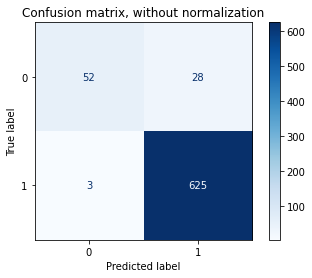

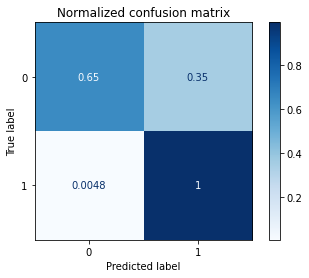

In [22]:
class_names = [ERROR, OK]

titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]

for title, normalize in titles_options:
    disp = plot_confusion_matrix(clf, X_test, y_test,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

Feature columns: ['central_farm', 'chaa_creek', 'hawkesworth_bridge']
Feature ranking:
1. feature 1 (0.446601)
2. feature 0 (0.399310)
3. feature 2 (0.154089)


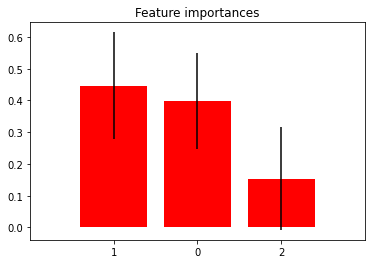

In [27]:
# Feature importance

print(f"Feature columns: {list(X_train.columns)}")

importances = clf.feature_importances_
# print(importances)

std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)

indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
        color="r", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), indices)
plt.xlim([-1, X_train.shape[1]])
plt.show()

In [28]:
X_val = data[['central_farm', 'chaa_creek', 'hawkesworth_bridge']]
y_val = data['label']
r = permutation_importance(clf, 
                           X_val, 
                           y_val,
                           n_repeats=30,
                           random_state=0)

for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
        print(f"{X_val.columns[i]:<8} "
              f"{r.importances_mean[i]:.3f}"
              f" +/- {r.importances_std[i]:.3f}")

hawkesworth_bridge 0.031 +/- 0.001
central_farm 0.021 +/- 0.001
chaa_creek 0.018 +/- 0.001


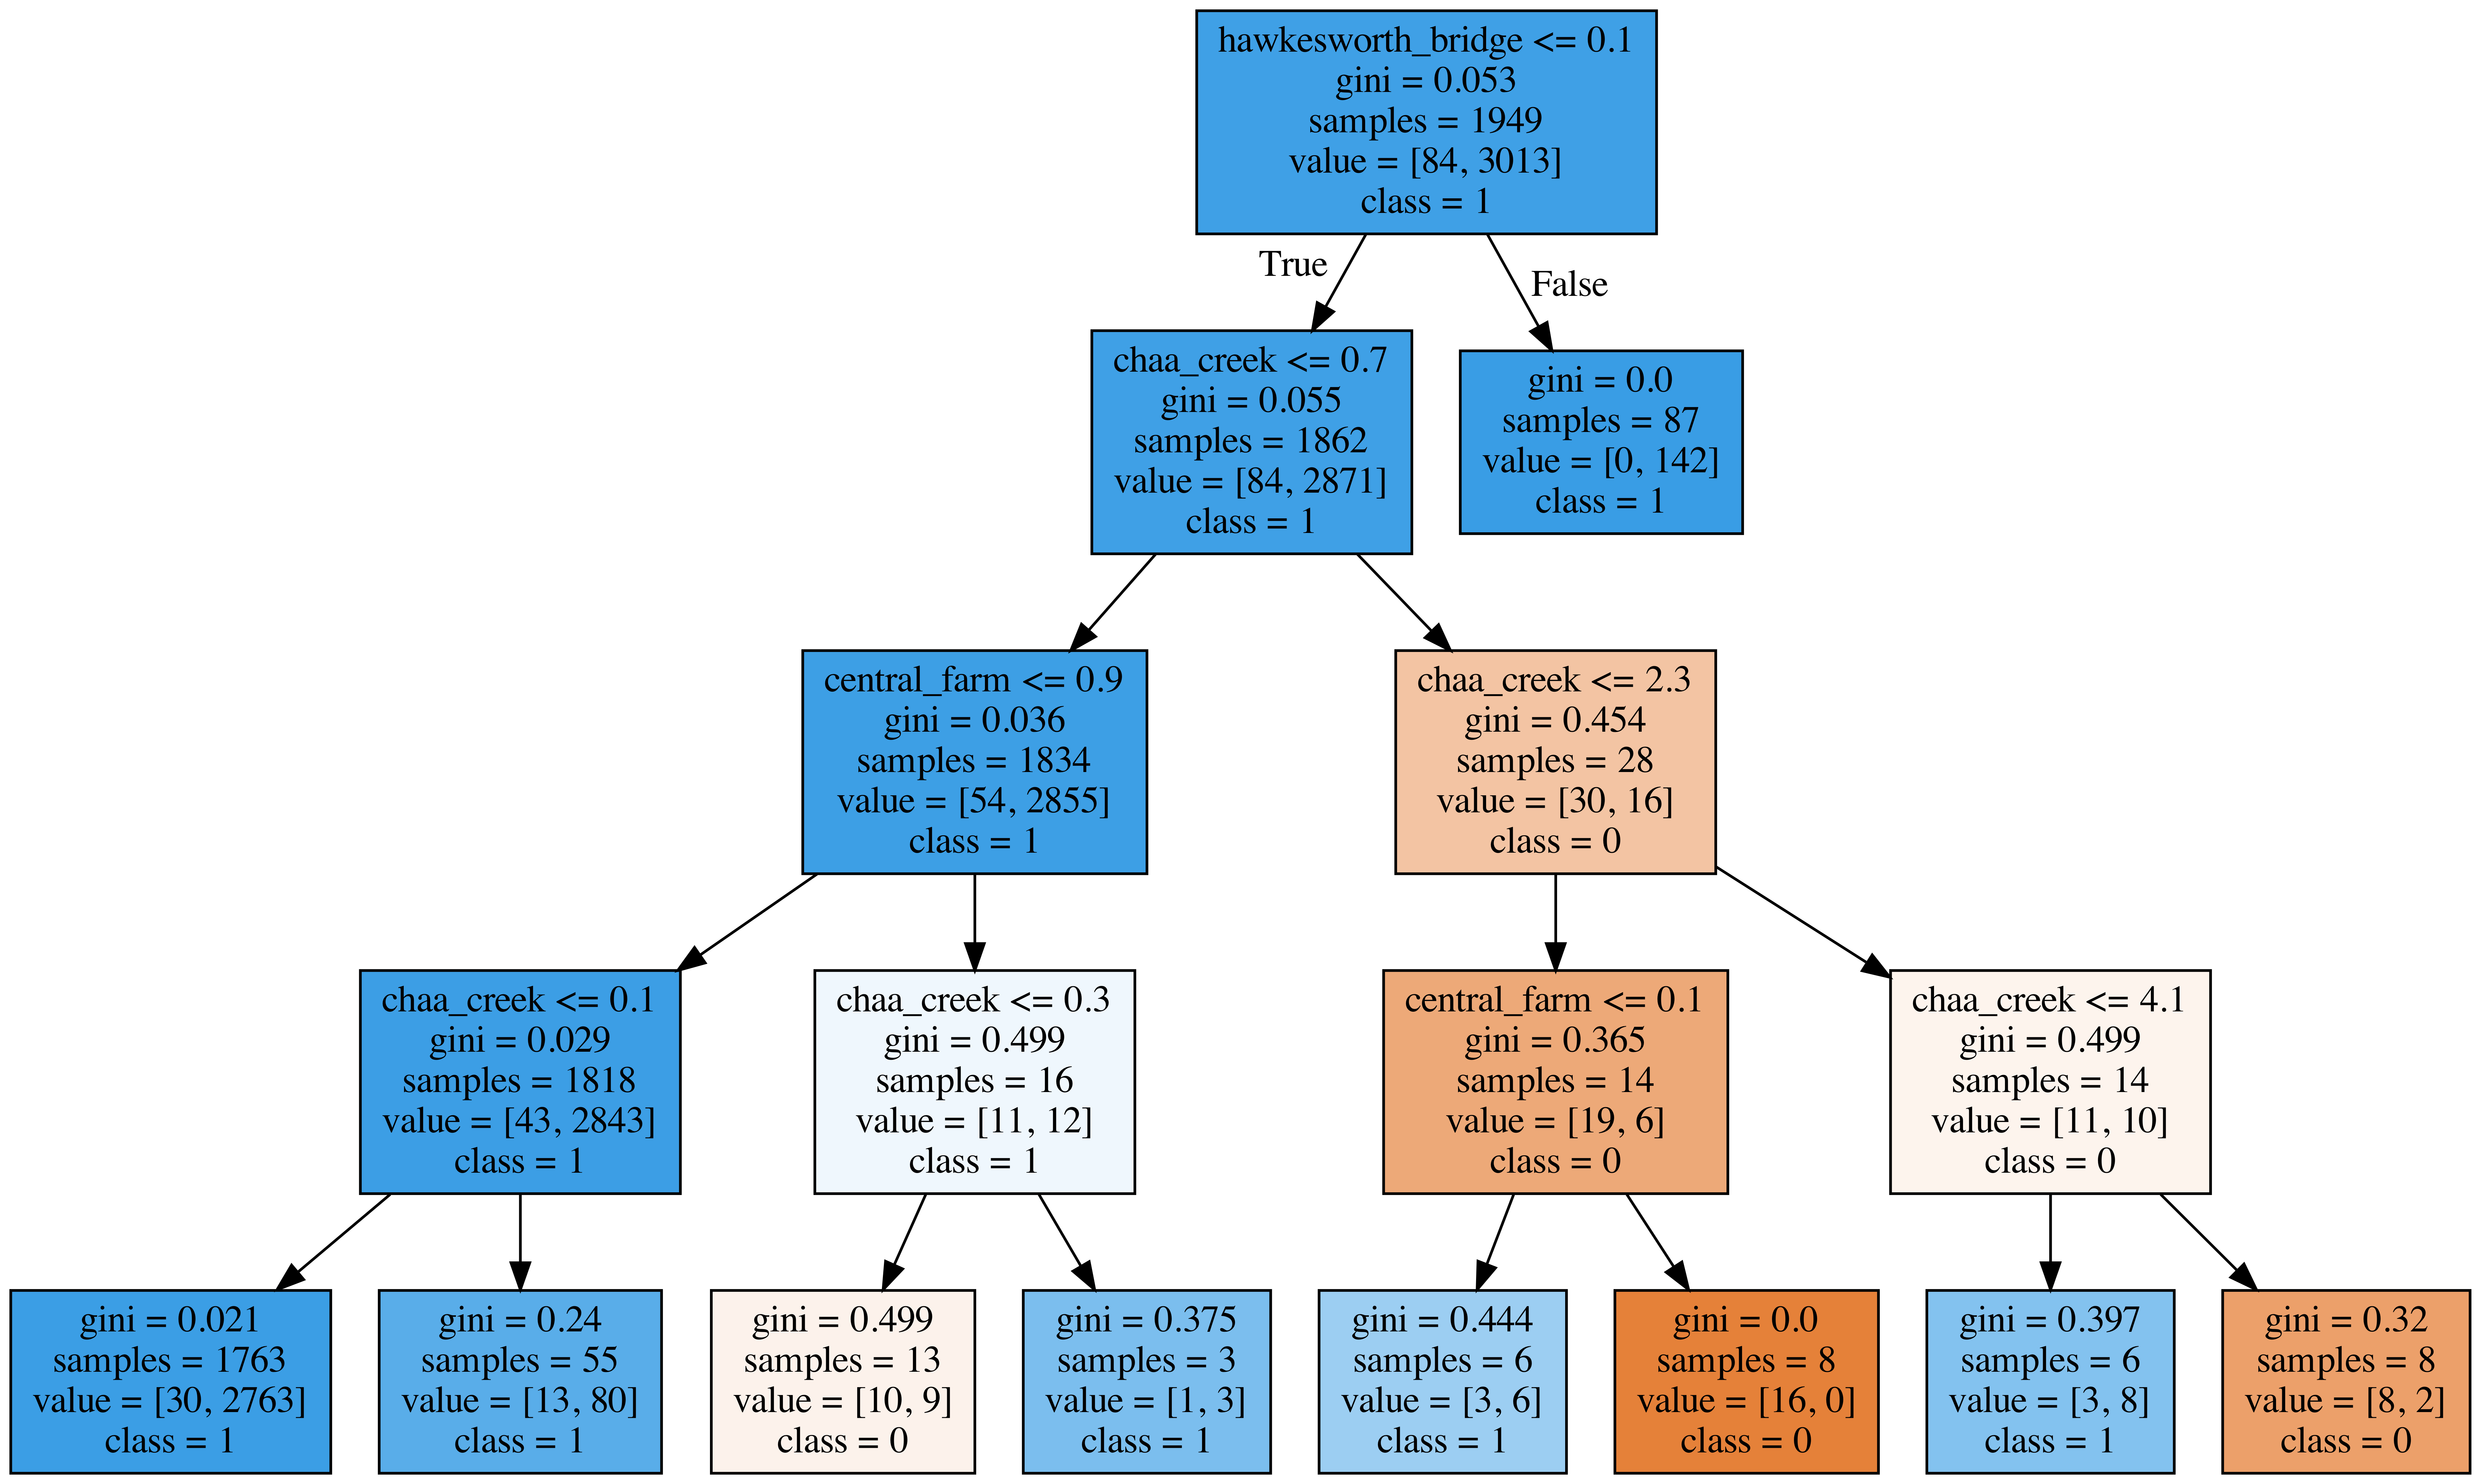

In [26]:
# Export as dot file
export_graphviz(clf.estimators_[0], 
                out_file='tree-hawkesworth_bridge-no-rain.dot', 
                feature_names=X_val.columns,
                class_names=['0', '1'],
                # rounded = True, 
                # proportion = False, 
                # precision = 2, 
                filled = True)

# Convert to png using system command (requires Graphviz)
from subprocess import call
call(['dot', '-Tpng', 'tree-hawkesworth_bridge-no-rain.dot', '-o', 'tree-hawkesworth_bridge-no-rain.png', '-Gdpi=600'])

# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'tree-hawkesworth_bridge-no-rain.png')

In [ ]:
# gerar gráfico com 10, 20, 50% dos dados

## Grid Search

In [98]:
from sklearn.model_selection import GridSearchCV

In [99]:
parameters = [{
    'max_depth': list(range(3,11)),
    'n_estimators': list(range(50, 501, 50))
}]
parameters

In [100]:
clf = GridSearchCV(
        RandomForestClassifier(), parameters, scoring='accuracy'
    )
clf.fit(X_train, y_train)

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid=[{'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
                          'n_estimators': [50, 100, 150, 200, 250, 300, 350,
                                           400, 450, 500]}],
             scoring='accuracy')

In [101]:
print(clf.best_params_)

{'max_depth': 5, 'n_estimators': 500}


In [ ]:
df_result.dtypes

In [ ]:

fig = px.line(df_result, x="minute", y="accuracy", title='Interval Accuracy')
fig.show()

## Find best aggregation interval

In [ ]:
# [10, 20, 30, 40, 50, 60, 120, 180, 240, 300, 360, 420, 480, 540, 600, 660, 720, 780, 840, 900, 960, 1020, 1080, 1140, 1200, 1260, 1320, 1380, 1440]
minutes = list(range(5, 60, 10))
minutes.extend(list(range(60, 24* 60 + 1, 60)))


results = []
for m in minutes:
    print(f"\n\nMinute: {m}")
    df_day = df_all.groupby([pd.Grouper(key="datetime", freq=f"{m}min"), "station", "station_id"]).sum()
    
    df_day.reset_index(inplace=True)
    
    data = df_day[['station', 'measured', 'datetime']].pivot(index='datetime', columns='station', values='measured')

    print(f"data before dropna: shape={data.shape}")
    data.dropna(inplace=True)
    print(f"data after  dropna: shape={data.shape}")

    X_train, X_test, y_train, y_test = split_df(data, 
                                            ['central_farm', 'chaa_creek', 'hawkesworth_bridge', 'santa_elena'],
                                            'label',
                                            datetime(2020, 11, 1).date())
    
    clf = RandomForestClassifier(max_depth=7, n_estimators=250)

    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)
    
    # Model Accuracy, how often is the classifier correct?
    accuracy = metrics.accuracy_score(y_test, y_pred)
    print("Accuracy: ", accuracy, "\n")
    results.append((m, accuracy))
    




In [ ]:
# árvore 4 níveis

# fazer gráfico com acurácia 10% dos dados até 50% dos dados

# dadod do IMERGE

In [30]:
data.head()

station                    central_farm  chaa_creek  hawkesworth_bridge  label
datetime                                                                      
2020-06-24 23:00:00+00:00           0.0         0.0                 0.0      1
2020-06-25 00:00:00+00:00           0.0         0.0                 0.0      1
2020-06-25 01:00:00+00:00           0.0         0.0                 0.0      1
2020-06-25 02:00:00+00:00           0.0         0.0                 0.0      1
2020-06-25 03:00:00+00:00           0.0         0.0                 0.0      1

In [103]:
# Chart Accuracy Using 10 to 50% by 5 

results = []

m = 60
print(f"\n\nMinute: {m}")
for perc in range(10, 51, 5):
    
    df_day_ = df_all.groupby([pd.Grouper(key="datetime", freq=f"{m}min"), "station", "station_id"]).sum()
    
    df_day_.reset_index(inplace=True)
    
    data_ = df_day_[['station', 'measured', 'datetime']].pivot(index='datetime', columns='station', values='measured')

    print(f"data before dropna: shape={data_.shape}")
    data_.dropna(inplace=True)
    print(f"data after  dropna: shape={data_.shape}")
    
    
    data_.loc[:, 'label'] = OK

    
    X_train_, X_test_, y_train_, y_test_ = split_df(data_, 
                                            ['central_farm', 'chaa_creek', 'hawkesworth_bridge'],
                                            'label',
                                            datetime(2020, 11, 1).date())
    
    
    
    idx_train = X_train_[X_train_['hawkesworth_bridge']>0].sample(frac=perc/100.0).index
    print(idx_train)
    X_train_.loc[idx_train, 'hawkesworth_bridge'] = 0.0 # no_rain
    y_train_.loc[idx_train] = ERROR
    
    idx_test = X_test_[X_test_['hawkesworth_bridge']>0].sample(frac=perc/100.0).index
    print(idx_test)
    X_test_.loc[idx_test, 'hawkesworth_bridge'] = 0.0 # no_rain
    y_test_.loc[idx_test] = ERROR
    
    data[(data['central_farm']>0) & (data['chaa_creek']>0) & (data['hawkesworth_bridge']>0)].shape
    data[(data['central_farm']>0) & (data['hawkesworth_bridge']>0) & ~((data['central_farm']>0) & (data['chaa_creek']>0) & (data['hawkesworth_bridge']>0))].shape
    data[(data['chaa_creek']>0)   & (data['hawkesworth_bridge']>0) & ~((data['central_farm']>0) & (data['chaa_creek']>0) & (data['hawkesworth_bridge']>0))].shape
    
    
    clf = RandomForestClassifier(max_depth=4, n_estimators=100)
    clf.fit(X_train_, y_train_)
    y_pred_ = clf.predict(X_test_)
    
    # Model Accuracy, how often is the classifier correct?
    accuracy_ = metrics.accuracy_score(y_test_, y_pred_)
    print(f"Accuracy: aggregation {m}min; {perc}% => {accuracy_}")
    results.append((m, perc, accuracy_))

    
df_result = pd.DataFrame(data=results, columns=['minute', 'perc', 'accuracy'])




Minute: 60
data before dropna: shape=(5412, 3)
data after  dropna: shape=(3805, 3)
X_train=(3097, 3), X_test=(708, 3), y_train=(3097,), y_test=(708,)
Int64Index([1960, 2680, 1045,   60, 1456, 3071, 2799, 1748, 2741, 2825, 2442,
            2671,   64, 1949, 1845, 2559, 1922, 2419, 2207, 1465, 1082, 3079],
           dtype='int64')
Int64Index([3562, 3206, 3654, 3580, 3145, 3199, 3605, 3192, 3582, 3170, 3551,
            3583, 3185, 3607, 3634, 3571, 3502, 3719, 3237],
           dtype='int64')
Accuracy: aggregation 60min; 10% => 0.9731638418079096
data before dropna: shape=(5412, 3)
data after  dropna: shape=(3805, 3)
X_train=(3097, 3), X_test=(708, 3), y_train=(3097,), y_test=(708,)
Int64Index([2671, 1116,  850, 1753,  855, 2109, 2674, 1948, 1534,  693, 2153,
             811, 2414, 2108, 1934, 1960, 3075, 2159, 1456, 2222, 2693, 2370,
            3026, 2741,  372, 1008, 1689, 1195,  373, 2374, 2442, 2811, 3073],
           dtype='int64')
Int64Index([3521, 3227, 3205, 3102, 3647, 356

Accuracy: aggregation 60min; 45% => 0.963276836158192
data before dropna: shape=(5412, 3)
data after  dropna: shape=(3805, 3)
X_train=(3097, 3), X_test=(708, 3), y_train=(3097,), y_test=(708,)
Int64Index([1046, 2739, 3024, 2796, 2353,  927,  239, 1508,   64, 1116,
            ...
            1925,  811, 1749, 1918,  235, 3063, 1753, 1844, 2757, 1365],
           dtype='int64', length=110)
Int64Index([3541, 3228, 3178, 3528, 3500, 3458, 3620, 3581, 3597, 3551, 3223,
            3185, 3162, 3187, 3522, 3549, 3499, 3165, 3116, 3225, 3194, 3506,
            3600, 3586, 3533, 3577, 3206, 3220, 3719, 3717, 3511, 3229, 3567,
            3509, 3119, 3607, 3596, 3718, 3573, 3708, 3561, 3515, 3160, 3102,
            3587, 3457, 3610, 3237, 3647, 3464, 3512, 3579, 3562, 3510, 3186,
            3145, 3505, 3215, 3542, 3191, 3514, 3523, 3193, 3623, 3170, 3113,
            3529, 3654, 3504, 3196, 3168, 3480, 3217, 3202, 3233, 3190, 3648,
            3195, 3463, 3635, 3531, 3469, 3564, 3197, 3552, 35

In [107]:
fig = go.Figure(data=[go.Bar(name='perc', x=df_result.perc, y=df_result.accuracy)])

fig.update_layout(
    title="Plot Title",
    xaxis_title="X Axis Title",
    yaxis_title="Percentage of error introduced",
    legend_title="Legend Title",
    font=dict(
        family="Courier New, monospace",
        size=18,
        color="RebeccaPurple"
    )
)

fig.show()

In [108]:
results

[(60, 10, 0.9731638418079096),
 (60, 15, 0.961864406779661),
 (60, 20, 0.9703389830508474),
 (60, 25, 0.96045197740113),
 (60, 30, 0.9576271186440678),
 (60, 35, 0.9562146892655368),
 (60, 40, 0.9392655367231638),
 (60, 45, 0.963276836158192),
 (60, 50, 0.9491525423728814)]

In [65]:
a = X_test[(X_test['central_farm']>0) & (X_test['chaa_creek']>0) & (X_test['hawkesworth_bridge']>0)].shape[0]
b = X_test[(X_test['central_farm']>0) & (X_test['hawkesworth_bridge']>0) & ~((X_test['central_farm']>0) & (X_test['chaa_creek']>0) & (X_test['hawkesworth_bridge']>0))].shape[0]
c = X_test[(X_test['chaa_creek']>0)   & (X_test['hawkesworth_bridge']>0) & ~((X_test['central_farm']>0) & (X_test['chaa_creek']>0) & (X_test['hawkesworth_bridge']>0))].shape[0]
s = X_test.shape[0]    

In [83]:


s # 708
a # 90
b # 6
c # 9

(c) / s 

0.012711864406779662

In [68]:
results

[(60, 10, 0.9759887005649718),
 (60, 15, 0.9661016949152542),
 (60, 20, 0.9548022598870056),
 (60, 25, 0.9463276836158192),
 (60, 30, 0.96045197740113),
 (60, 35, 0.9576271186440678),
 (60, 40, 0.963276836158192),
 (60, 45, 0.9491525423728814),
 (60, 50, 0.9533898305084746)]

In [91]:
X_test_.loc[(y_pred_ == y_test_) & (X_test_.sum(axis=1)>0)]

station  central_farm  chaa_creek  hawkesworth_bridge
3102              0.0         0.2                 0.4
3113              0.0         0.0                 0.4
3114              0.2         0.2                 0.0
3116              6.6         1.8                 0.0
3118              0.2         0.0                 0.0
...               ...         ...                 ...
3718              9.0         3.2                 0.0
3719              1.0         1.6                 2.6
3738              0.2         0.0                 0.2
3739              0.0         0.2                 0.0
3789              0.0         0.0                 5.0

[209 rows x 3 columns]

In [92]:
df = X_test_.copy()
df['y_test_'] = y_test_
df['y_pred_'] = y_pred_

In [109]:
df.loc[(df.y_pred_ == df.y_test_) & (df[['central_farm', 'chaa_creek', 'hawkesworth_bridge']].sum(axis=1)>0)]

station  central_farm  chaa_creek  hawkesworth_bridge  y_test_  y_pred_
3102              0.0         0.2                 0.4        1        1
3113              0.0         0.0                 0.4        1        1
3114              0.2         0.2                 0.0        1        1
3116              6.6         1.8                 0.0        0        0
3118              0.2         0.0                 0.0        1        1
3119              0.0         0.0                 0.2        1        1
3123              0.2         0.0                 0.0        1        1
3124              0.0         2.6                 0.0        1        1
3138              0.0         0.2                 0.0        1        1
3141              0.0         0.2                 0.0        1        1
3142              0.0         0.2                 0.0        1        1
3144              8.2        13.0                 0.0        0        0
3145              0.4         0.6                 0.4        1        1
3146              4.4         2.6                 4.4        1        1
3147              0.8         3.4                 0.0        0        0
3150              0.0         0.2                 0.0        1        1
3159              0.6         3.0                 2.2        1        1
3160              2.4         2.4                 0.0        0        0
3161              0.8         1.2                 0.0        0        0
3162              0.6         1.6                 1.0        1        1
3163              0.4         1.2                 1.0        1        1
3164              0.2         0.2                 0.0        1        1
3165              1.2         2.0                 0.0        0        0
3166              1.6         3.2                 0.0        0        0
3167              0.2         0.6                 0.0        1        1
3168              2.8         3.4                 1.8        1        1
3169              0.4         0.2                 0.0        1        1
3170             11.0         6.0                 5.8        1        1
3171              7.6        21.6                 9.8        1        1
3172              1.0         6.2                 2.0        1        1
3174              1.2         2.2                 0.0        0        0
3175              0.6         1.4                 0.0        0        0
3176              0.4         1.0                 0.0        0        0
3177              0.0         1.0                 0.0        1        1
3178              0.8         1.0                 0.6        1        1
3184              3.2         5.4                 2.4        1        1
3185              3.0         4.2                 0.0        0        0
3186              1.4         1.8                 0.6        1        1
3187              1.2         2.4                 0.0        0        0
3188              2.8         3.4                 2.8        1        1
3189              0.4         1.2                 0.4        1        1
3190              2.0         2.6                 0.0        0        0
3191              0.2         0.2                 2.2        1        1
3192              3.4         3.2                 2.8        1        1
3193              1.4         1.8                 1.0        1        1
3194              0.6         1.6                 0.0        0        0
3196              7.4         6.0                 4.8        1        1
3197              3.2         6.0                 0.0        0        0
3198              3.6         2.6                 0.0        0        0
3199              0.2         1.2                 0.8        1        1
3201              6.4         8.0                 5.2        1        1
3202              1.2         3.0                 0.0        0        0
3203              1.0         3.4                 0.0        0        0
3204              1.0         0.8                 0.0        0        0
3206              0.6         1.4       

In [60]:
data[(data['central_farm']>0) & (data['chaa_creek']>0) & (data['hawkesworth_bridge']>0)].shape # 146

(146, 4)

In [63]:
data[(data['central_farm']>0) & (data['hawkesworth_bridge']>0) & ~((data['central_farm']>0) & (data['chaa_creek']>0) & (data['hawkesworth_bridge']>0))].shape

(31, 4)

In [64]:
data[(data['chaa_creek']>0) & (data['hawkesworth_bridge']>0) & ~((data['central_farm']>0) & (data['chaa_creek']>0) & (data['hawkesworth_bridge']>0))].shape

(36, 4)